# K-Means Clustering Algorithm

The intent of this file is to demonstrate an understanding of the K-Means clustering algorithm, and design a single function which will identify K clusters when provided a dataframe, value for K, threshold, and number of "starts".  It is derived from first principles, and relies only on pandas, numpy, and matplotlib to create its clusters.

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as pl
import matplotlib.cm as cm

In [5]:
a = np.random.randn(50,2)+np.array([-4,1])
b = np.random.randn(50,2)+np.array([-1,-4])
c = np.random.randn(50,2)+np.array([1,4])
d = np.random.randn(50,2)+np.array([-8,10])
e = np.random.randn(50,2)+np.array([-8,-10])
f = np.random.randn(50,2)+np.array([-8,10])
g = np.random.randn(50,2)+np.array([-6,-2])
h = np.random.randn(50,2)+np.array([-6,2])
i = np.random.randn(50,2)+np.array([-6,-2])
t = np.concatenate([a,b,c,d,e,f,g,h,i],axis=0)

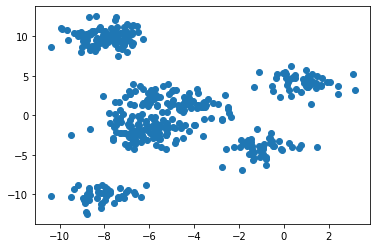

In [6]:
pl.scatter(t[:,0],t[:,1])

In [7]:
def scaler(df):
    #Calculate the mean, minimum, and maximum value for each feature, and scale the values for each feature between 0 and 1
    #Ultimately, this will optimize performance on datasets with features which differ significantly in magnitude
    mean = df.mean(axis=0)
    mins = df.min(axis=0)
    maxs = df.max(axis=0)
    df = (df-mean)/(maxs-mins)
    return(df)

In [8]:
def initialize_centers(k,df):
    #Randomly generate k centers to initialize the k-means algorithm
    n = df.shape[1]
    mean = np.mean(df,axis=0)
    c = scaler((np.random.rand(k,n)-0.5+mean))
    return(c)

In [9]:
def center_colors(c):
    #Generate unique color codes for k centers being evaluated
    colors=[]
    color=iter(cm.rainbow(np.linspace(0,1,c.shape[0])))
    for i in range(c.shape[0]):
        col=next(color)
        colors.append(col)
    return(colors)

In [10]:
def plot_centers(c,colors):
    #Plot the centers themselves along with the dataset being investigated
    for i in range(c.shape[0]):
        pl.plot(c[i,0],c[i,1],c=colors[i],marker='.',linestyle='',markersize=20)

In [11]:
def principle_components(df):
    #Find the first and second principle components of the dataset to plot the ceters simply
    #By always plotting on the first and second principle components, any k-means solution
    #can be displayed graphically regardless of feature count
    df = scaler(df)
    m = df.T
    cm = np.cov(m)
    val,vec = np.linalg.eig(cm)
    proj_1 = df.dot(vec.T[0])
    proj_2 = df.dot(vec.T[1])
    res = pd.DataFrame(proj_1,columns=['PC1'])
    res['PC2'] = proj_2
    df = np.array(res)
    return(df)

In [12]:
def distance(df,ci):
    #Calculate the Euclidean distance between two points or vectors
    d = df-ci
    d = np.sum(np.power(d,2),axis=1)
    return(d)

In [13]:
def center_table(df, c, k):
    #Generate the pandas data structure which stores the Euclidean distance of each point to each of k centers
    n = c.shape[1]
    df0 = df
    df = pd.DataFrame(df)
    for i in range(c.shape[0]):
        new_df = distance(df0,c[i,:])
        new_df = pd.DataFrame(new_df,columns=[f'{i}'])
        df = pd.concat([df, new_df],axis=1)
    centers = df.iloc[:,n:(k+n)]
    center_mins = pd.DataFrame(centers.idxmin(axis=1),columns=['clusters'])
    df = pd.concat([df,center_mins],axis=1)
    return(df)

In [14]:
def new_centers(df, c, k):
    #After determining which center is closest to each point, the coordinates for each center are calculated for the next iteration
    n = c.shape[1]
    holder = np.random.random_sample((k,n))
    cmi = n+k
    cm = pd.DataFrame(df.iloc[:,cmi])
    feat = pd.DataFrame(df.iloc[:,0:n])
    df = pd.concat([cm, feat], axis=1)
    dfg = df.groupby(['clusters']).agg(np.mean).reset_index()
    for i in range(dfg.shape[0]):
        holder[int(dfg.iloc[i,0]),0] = dfg.iloc[i,1]
        holder[int(dfg.iloc[i,0]),1] = dfg.iloc[i,2]
    c = holder
    return([df, c])

In [15]:
def optimized_centers(df, k, threshold):
    #Execute the k-means clustering algorithm until the movement of each center does not exceed the magnitude of a user-specified threshold
    e = 1000
    c = initialize_centers(k, df)
    df = principle_components(df)
    df = center_table(df, c, k)
    ci = c
    i = 1
    while e > threshold:
        dfi, ci = new_centers(df, ci, k)
        e = np.sqrt(np.sum(distance(c,ci)))
        c = ci
        i = i+1
        if i == 2000:
            continue
    return(df, c)

In [16]:
def start(df, c, k):
    #Execute the optimized_centers() function, and store the percent of variance explained by the number of clusters as the output
    n = c.shape[1]
    holder = np.random.random_sample((k,n))

    features = df.iloc[:,0:n]
    clusters = df.iloc[:,n+k]

    dfi = pd.concat([clusters,features],axis=1)
    dfi_mean = np.array(np.mean(dfi.iloc[:,1:n+1],axis=0))
    dfi_diffs = np.array(features)-dfi_mean
    dfi_sq_diffs = np.square(dfi_diffs)
    tss = np.sum(dfi_sq_diffs)

    dfi_ind_mean = dfi.groupby(['clusters']).agg(np.mean)
    dfi_ind_mean = pd.DataFrame(dfi_ind_mean)
    for i in range(dfi_ind_mean.shape[0]):
        holder[int(dfi_ind_mean.iloc[i,0]),0] = dfi_ind_mean.iloc[i,0]
        holder[int(dfi_ind_mean.iloc[i,0]),1] = dfi_ind_mean.iloc[i,1]
    dfi_ind_mean = holder

    e = []
    for i in range(k):
        dfj = dfi[dfi['clusters']==f'{i}']
        dfj = dfj.iloc[:,1:n+1]
        dfj = np.array(dfj)

        dfm = dfi_ind_mean[i,:]

        dfj_diffs = dfj-dfm
        dfj_sq_diffs = np.square(dfj_diffs)
        tot_dfj_sq_diff = np.sum(dfj_sq_diffs)
        e.append(tot_dfj_sq_diff)
    rss = np.sum(e)

    var = 1-(rss/tss)
    return(var)

In [17]:
def kmeans(df, k, threshold, nstart):
    #Run start() nstart times, and select the clustering solution which resulted in the maximal variance explained of all iterations
    start_var = pd.DataFrame(np.zeros((nstart,1)))
    start_output = []
    
    for i in range(nstart):
        dfi, ci = optimized_centers(df, k, threshold)
        var = start(dfi, ci, k)
        
        start_output.append([dfi,ci])
        start_var.iloc[i,0] = var
    
    idx = start_var.idxmax()[0]
    df = start_output[idx][0]
    c = start_output[idx][1]
    
    return(df, c)

In [18]:
def kmeans_plot(df, c):
    #Plot the centers calculated by the k-means algorithm
    colors = center_colors(c)
    pl.plot(df.iloc[:,0],df.iloc[:,1],marker='.',linestyle='')
    plot_centers(c,colors)
    pl.show

In [19]:
df_f, c_f = kmeans(t, k=5, threshold=0.1, nstart=100)

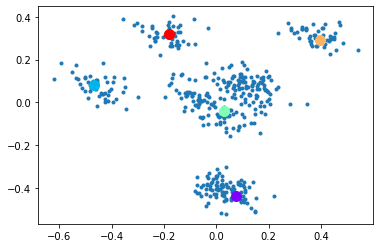

In [20]:
kmeans_plot(df_f,c_f)

In [21]:
df_f

,0,1,0,1,2,3,4,clusters
0,0.029524,-0.073471,0.368080,0.507516,0.006770,0.171124,0.315852,2
1,-0.030552,0.028508,0.525125,0.370090,0.003379,0.250810,0.197319,2
2,-0.011815,-0.012819,0.462505,0.416166,0.001033,0.220118,0.239691,2
3,-0.034954,0.041593,0.544527,0.357982,0.004993,0.259946,0.185305,2
4,-0.173988,0.091293,0.743027,0.204781,0.032497,0.432065,0.118654,2
...,...,...,...,...,...,...,...,...
445,0.095002,0.030046,0.438839,0.519239,0.021606,0.150313,0.257637,2
446,-0.009858,0.138598,0.651549,0.340897,0.028946,0.284899,0.128235,2
447,0.127704,0.036457,0.428752,0.559835,0.032279,0.131601,0.273714,2
448,0.071017,0.020429,0.441855,0.493783,0.014680,0.163684,0.251294,2
